# Power law $\gamma$ vs Hölder exponent $h$

In order to extend the MnGSeg technique to multifractal analysis it is important to understand how the Morlet wavelet is related to the Hölder exponent $h$.

Accoding to [Khalil et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJS..165..512K/abstract), the relation between the power law $\gamma$ and the Hölder exponent is

$$\gamma = 2+2h$$

[Khalil et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJS..165..512K/abstract) measure directly the Hölder exponent form the gradient amplitude of the their wavelet coefficients:

$$\mathcal{M}_{\psi}[f][\mathcal{L}_{x_0}(a)] \sim a^{h(x_0)}$$

where

$$\mathcal{M}_{\psi}[f](\mathbf{b},a) = \sqrt{\{T_{\psi1}[f](\mathbf{b},a)\}^2 + \{T_{\psi2}[f](\mathbf{b},a)\}^2}$$

and

$$\mathbf{T}_{\psi12}[f](\mathbf{b},a) = a^{-2}\int d^2\mathbf{x}\psi_{12}[a^{-1}(\mathbf{x-b})]f(x)$$

$$\psi_1(x,y) = \partial \phi_{\textrm{Gau}}(x,y)/\partial x$$
$$\psi_2(x,y) = \partial \phi_{\textrm{Gau}}(x,y)/\partial y$$

The two wavelets $\psi_1$ and $\psi_2$ are the partial derivative of a 2D Gaussian Kernel according to $x$ and $y$. The wavelets are dilated with the scaling factor $a$ and translated through $b$.

In [Robitaille et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv190511492R/abstract), the wavelet transform is defined in equation (5)

$$\tilde{f}(l,\vec{x})= \frac{1}{l} \int \int_{-\infty}^{+\infty} f(\vec{x}')\psi^*\Big(\frac{\vec{x}'-\vec{x}}{l}\Big)d\vec{x}'$$

where the scaling factor is now defined by $l$. The wavelet power spectrum is defined as

$$P^W(l)=\int \int_{-\infty}^{\infty} |\tilde{f}(l,\vec{x})|^2 d\vec{x}.$$

This wavelet power spectrum is proportional to $k^{-\gamma}$, where in the case of the Morlet wavelet $l=k_0/k$ for $k_0= 5.336$.

So comparing these equations, the Hölder exponent should correspond to

$$\sum_{\mathbf{x}} |\tilde{f}(l,\mathbf{x})| \propto l^h$$

In [1]:
%pylab inline
plt.style.use(['dark_background'])

from pywavan import fbm2d, powspec, fan_trans

Populating the interactive namespace from numpy and matplotlib


gamma fit= -3.6419652093266457
h= 0.8300000000000001
h fit= 0.83173292568891


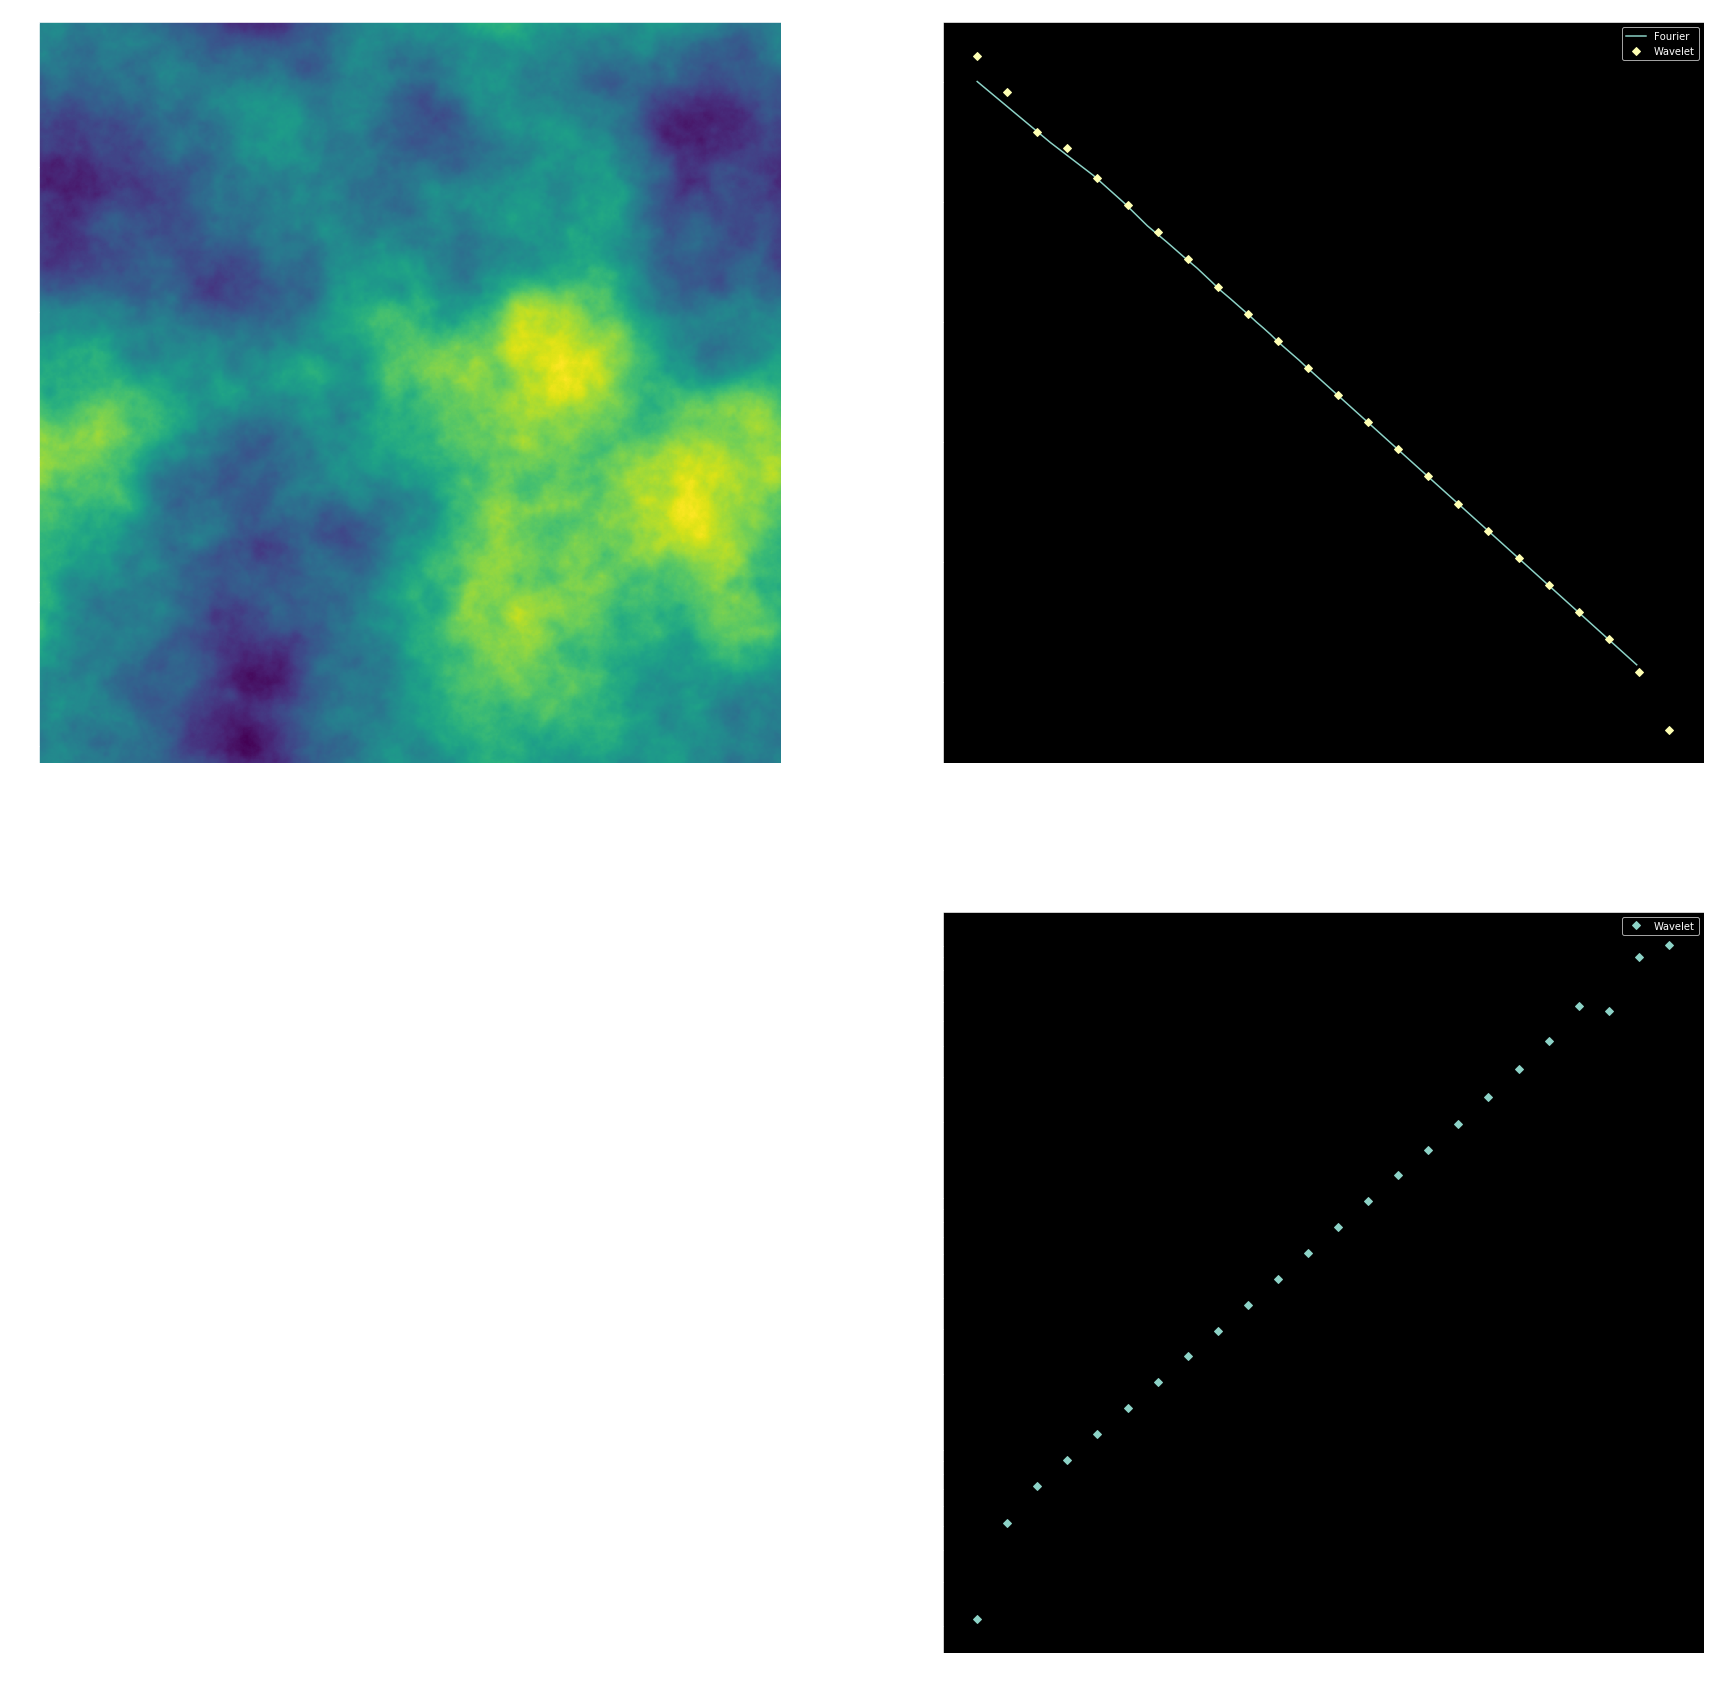

In [27]:
gamma = -3.66
na = 1024
nb = 1024

fbm = fbm2d(gamma,na,nb)

h = (-1.*gamma - 2.) / 2.

#Fourier power spectrum
tab_k, spec_k = powspec(fbm, reso=1)

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(fbm, reso=1, q=0, qdyn=False, angular=True)

#Alternate normalisation for the wavelet spectrum
ko= 5.336
a = 1. / wav_k
h1a = np.sum(np.abs(wt),(1,2,3))

figure(figsize=(30,30))
subplot(2,2,1)
imshow(fbm)
title('Fractional Brownian motion')

subplot(2,2,2)
plot(tab_k, spec_k, label='Fourier')
plot(wav_k, S1a,'D', label='Wavelet')
xscale('log')
yscale('log')
legend()
title('Power spectrum')

subplot(2,2,4)
plot(a, h1a,'D', label='Wavelet')
xscale('log')
yscale('log')
legend()
title('Hölder index')

#Fit
ecart = range(2,18)
Bg = np.polyfit(log(wav_k[ecart]), log(S1a[ecart]), 1)
Bh = np.polyfit(log(a[ecart]), log(h1a[ecart]), 1)

print('gamma fit=',Bg[0])
print('h=',h)
print('h fit=',Bh[0])

We are able to reproduce the Hölder exponent directly from the wavelet coefficients. Some deviations exist at small and large scale perhaps due to respectively the pixelisation and the finite size of the map.

### Now, can we derive the Multifractal spectrum of these wavelet coefficients?

According to [Kestener et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...717..995K/abstract) (which exposes the same method than Khalil et al. 2006 in a simple manner), in order to get the multifractal dimension one has to compute the partition functions first:

$$\mathcal{Z}(q,l) = \sum_{\mathbf{x}} |\tilde{f}(l,\mathbf{x})|^q$$

In [25]:
#Number of fBm realisations
Nfbm = 32

M = wav_k.size
q = range(-3,5)
Zq = np.zeros((len(q),M))
tauq = np.zeros(len(q))

for k in range(Nfbm):
    fbm = fbm2d(gamma,na,nb)
    wt, S11a, wav_k, S1a, qq = fan_trans(fbm, reso=1, q=0, qdyn=False, angular=True)
    a = 1. / wav_k
    for j in range(M):
        for i in range(len(q)):
            wt2 = np.abs(wt[j,:,:,:])
            Zq[i,j] = Zq[i,j] + np.sum(a[j]**-2*wt2**q[i])

for i in range(len(q)):
    tauq[i],junk = np.polyfit(log(a[ecart]), log(Zq[i,ecart]/Nfbm), 1)
    
figure(figsize(24,9))
subplot(1,2,1)
for i in range(len(q)):
    plot(a,Zq[i,:],label=q[i],marker='d')
xscale('log')
yscale('log')
legend()

title('Z(q,l)')

subplot(1,2,2)
plot(q,tauq)
title('tau(q)')

KeyboardInterrupt: 

Then, the Legendre transform of the $\tau(q)$ function should give the multifractal spectrum $D(h)$:

$$D(h) = qh - \tau(q)$$

where

$$h = \frac{d\tau(q)}{dq}$$

In [15]:
from scipy import interpolate

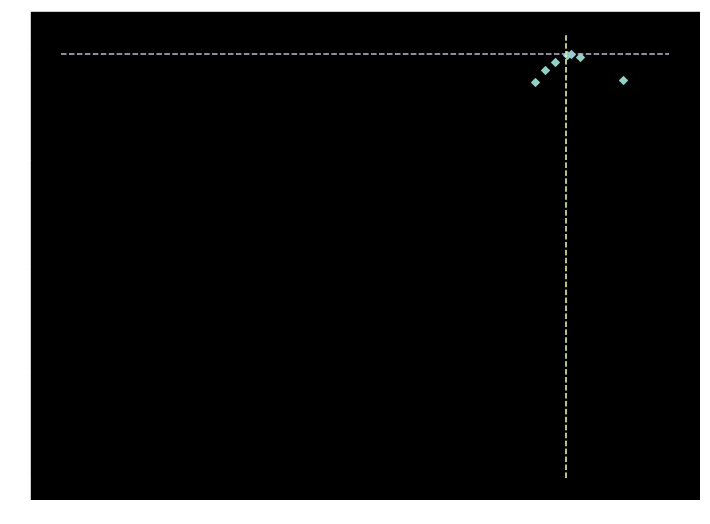

In [20]:
tck = interpolate.splrep(q[1:],tauq[1:])
holder = interpolate.splev(q[1:],tck,der=1)

Dh = q[1:] * holder - tauq[1:]

figure(figsize(12,9))
plot(holder,Dh,'D')
plot([h,h],[0.,2.1],'--')
plot([0.0,1.0],[2.,2.],'--')
#xlim((0.0,1.0))
#ylim((-1.75,0.1))

In [24]:
q[1:]

range(-2, 5)